In [62]:
import os
import pickle
import numpy as np
import pandas as pd
import torch as T
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set_theme() 

import random
from tqdm.notebook import tqdm

C:\Users\Niworld\AppData\Local\Temp\ipykernel_19328\1301542116.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [63]:
def weather2power(weather, power_WT = 1000, power_PV = 1):
    power_renergy = power_WT*weather[0] + power_PV*weather[1]
    return power_renergy/100

In [64]:
def charge2power(charge, pro):
    if pro > (1-charge[0]-charge[1]):
        power_charge = 0
    else: 
        power_charge = 50
    return power_charge

In [65]:
def charge2reward(charge, pro, error):
    if pro > (1-charge[0]-charge[1]):
        reward = 0
    elif pro < charge[0]*error:
        reward = 60
    else:
        reward = 100
    return reward

In [66]:
def traffic2power(traffic, traffic_max = 150):
    power_BS = 2*traffic/traffic_max+2
    return power_BS

In [67]:
def load_RTP(T=31, train_flag=True):
    if train_flag:
        df = pd.read_table('../Data/RTP.csv', sep=",", nrows=24*T, skiprows=24*random.randint(0, 570))
    else:
        df = pd.read_table('../Data/RTP.csv', sep=",", nrows=24*T, skiprows=24*random.randint(600, 699))
    df = df.to_numpy()
    RTP = []
    for data in df:        
        RTP.append(float(data[1][data[1].find("$")+1:]))
    return RTP

In [68]:
def load_weather(T=31, train_flag=True):
    if train_flag:
        df = pd.read_table('../Data/weather.csv', sep=",", nrows= 24*T, skiprows=24*random.randint(0, 570))
    else:
        df = pd.read_table('../Data/weather.csv', sep=",", nrows= 24*T, skiprows=24*random.randint(600, 699))
    df = df.to_numpy() 
    weather = []
    for data in df:
        data = data[1].split(",")
        weather.append([float(data[-2]), float(data[-4])])
    return weather

In [69]:
# shape [192,1]
def load_traffic(T=31, train_flag=True):
    file = open("../Data/traffic", "rb")
    bytes_list = pickle.load(file)
    bytes_list = np.r_[bytes_list, bytes_list, bytes_list, bytes_list]
    return list(bytes_list)

In [70]:
# [incentive, always]
def load_charge(T=31, train_flag=True):
    file = open("../Data/charge", "rb")
    charge = pickle.load(file)
    return charge.tolist()*31

In [71]:
len(load_charge())

744

In [72]:
class BS_EV():
    def __init__(self, n_charge = 24, n_traffic=24, n_RTP = 24, n_weather = 24, train_flag = True, error=1.0):
        #self.n_app = n_app
        #self.n_actions = 2**n_app*3
        self.n_states = n_RTP + 2*n_weather + n_traffic + 2*n_charge + 1 # RTP + weather + traffic + charge + SOC
        self.n_traffic = n_traffic
        self.n_actions = 3
        self.RTP = []  # real time price
        self.weather = [] # weather condition (WT, PV)
        self.traffic = []
        self.charge = []
        self.SOC = 0  # percentage of SOC
        self.n_RTP = n_RTP # length of RTP in state
        self.n_weather = n_weather # length of weather in state
        self.done = False # flag to illustrate the end of an episode
        
        self.T = 0 # time index

        self.min_SOC = 0.2 # minimal SOC
        self.SOC_charge_rate = 0.1 # charge rate of SOC
        self.SOC_discharge_rate = 0.1 # discharge rate of SOC
        self.SOC_per_cost = 0.01 # operation cost of each usage of ESS
        self.SOC_eff = 1.1 # charge/discharge efficiency
        self.AC_DC_eff = 1.1 # AC/DC conversion efficiency
        self.ESS_cap = 500 # capacity of ESS
        self.n_charge = n_charge # strata prediction of each time slot
        self.train_flag = train_flag # train or test
        self.error = error
        
    def reset(self):
        self.SOC = random.uniform(self.min_SOC, 1) # reset SOC to a random percentage
        self.T = 0
        self.RTP = load_RTP(train_flag = self.train_flag)
        self.weather = load_weather(train_flag = self.train_flag)
        self.traffic = load_traffic()
        self.charge = load_charge()
        self.done = False
        
        observation = [self.RTP[self.T:self.T+self.n_RTP], self.weather[self.T:self.T+self.n_weather], self.traffic[self.T:self.T+self.n_traffic], self.charge[self.T:self.T+self.n_charge], [self.SOC]]
        observation[1] = list(np.concatenate(observation[1]). flat)
        observation[3] = list(np.concatenate(observation[3]). flat)
        observation = list(np.concatenate(observation). flat)
        return observation
        
    def step(self, action):
        
        action_SOC = action  # 0-not use; 1-charge; 2-discharge
        
        # check operation of SOC
        if (self.SOC < self.min_SOC+self.SOC_discharge_rate and action_SOC == 2) or (self.SOC > 1-self.SOC_charge_rate and action_SOC == 1):
            action_SOC = 0
   
        # ESS cost
        SOC_cost = 0 if action_SOC == 0 else self.SOC_per_cost
        
        # power cost
        pro = random.uniform(0, 1)
        power_charge = charge2power(self.charge[self.T], pro)
        power_BS = traffic2power(self.traffic[self.T])
        power_renergy = weather2power(self.weather[self.T])# discharge power of renewable energy
        
        if action_SOC == 1: # ESS charge
            self.SOC = self.SOC + self.SOC_charge_rate
            power = max(power_BS*self.AC_DC_eff + power_charge + self.SOC_charge_rate*self.ESS_cap*self.SOC_eff - power_renergy, 0)
        elif action_SOC == 2: # ESS discharge 
            self.SOC = self.SOC - self.SOC_discharge_rate
            power = max(power_BS + power_charge - self.SOC_discharge_rate*self.ESS_cap*self.SOC_eff - power_renergy, 0)
        else: # ESS not use
            power = max(power_BS*self.AC_DC_eff + power_charge - power_renergy, 0)
        # print(power_app, power_renergy)
        power_cost = self.RTP[self.T]*power/100
        # calculate reward
        reward_charge = charge2reward(self.charge[self.T], pro, self.error)
        reward = reward_charge - SOC_cost - power_cost
        
        self.T += 1
        next_state = [self.RTP[self.T:self.T+self.n_RTP], self.weather[self.T:self.T+self.n_weather], self.traffic[self.T:self.T+self.n_traffic], self.charge[self.T:self.T+self.n_charge], [self.SOC]]
        next_state[1] = list(np.concatenate(next_state[1]). flat)
        next_state[3] = list(np.concatenate(next_state[3]). flat)
        next_state = list(np.concatenate(next_state). flat)

        if (self.T) % (24*30) == 0:
            self.done = True
        
        return next_state, reward, self.done

In [73]:
device = T.device("cuda" if T.cuda.is_available() else "cpu")

In [74]:
env = BS_EV()

In [75]:
env.reset()

[np.float64(23.97),
 np.float64(24.22),
 np.float64(24.7),
 np.float64(28.28),
 np.float64(32.08),
 np.float64(38.82),
 np.float64(22.29),
 np.float64(20.21),
 np.float64(19.68),
 np.float64(19.97),
 np.float64(21.3),
 np.float64(30.42),
 np.float64(34.94),
 np.float64(30.89),
 np.float64(35.28),
 np.float64(39.78),
 np.float64(47.41),
 np.float64(40.48),
 np.float64(40.6),
 np.float64(32.49),
 np.float64(29.73),
 np.float64(22.08),
 np.float64(22.55),
 np.float64(21.84),
 np.float64(0.30000000000000004),
 np.float64(0.0),
 np.float64(0.30000000000000004),
 np.float64(0.0),
 np.float64(0.30000000000000004),
 np.float64(0.0),
 np.float64(0.30000000000000004),
 np.float64(0.0),
 np.float64(0.4),
 np.float64(0.0),
 np.float64(0.4),
 np.float64(0.0),
 np.float64(0.4),
 np.float64(87.0),
 np.float64(0.5),
 np.float64(143.0),
 np.float64(0.5),
 np.float64(167.0),
 np.float64(0.5),
 np.float64(179.0),
 np.float64(0.5),
 np.float64(176.0),
 np.float64(0.5),
 np.float64(162.0),
 np.float64(0.5)

In [76]:
next_state, reward, done = env.step(3)

In [77]:
reward

np.float64(47.94701289059286)

In [79]:
class ActorNetwork(nn.Module):
    def __init__(self, n_actions, input_dims, alpha,
            fc1_dims=256, fc2_dims=256, chkpt_dir='../tmp/'):
        super(ActorNetwork, self).__init__()

        self.checkpoint_file_best = os.path.join(chkpt_dir, 'actor_torch_ppo_best')
        self.checkpoint_file_last = os.path.join(chkpt_dir, 'actor_torch_ppo_last')
        self.actor = nn.Sequential(
                nn.Linear(input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, n_actions),
                nn.Softmax(dim=-1)
        )

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device("cuda" if T.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, state):
        #print(state)
        dist = self.actor(state)
        dist = Categorical(dist)
        
        return dist

    def save_checkpoint_best(self):
        T.save(self.state_dict(), self.checkpoint_file_best)
        
    def save_checkpoint_last(self):
        T.save(self.state_dict(), self.checkpoint_file_last)

    def load_checkpoint_best(self):
        self.load_state_dict(T.load(self.checkpoint_file_best))
        
    def load_checkpoint_last(self):
        self.load_state_dict(T.load(self.checkpoint_file_last))

class CriticNetwork(nn.Module):
    def __init__(self, input_dims, alpha, fc1_dims=256, fc2_dims=256,
            chkpt_dir='../tmp/'):
        super(CriticNetwork, self).__init__()

        self.checkpoint_file_best = os.path.join(chkpt_dir, 'critic_torch_ppo_best')
        self.checkpoint_file_last = os.path.join(chkpt_dir, 'critic_torch_ppo_last')
        self.critic = nn.Sequential(
                nn.Linear(input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, 1)
        )

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device("cuda" if T.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, state):
        value = self.critic(state)

        return value

    def save_checkpoint_best(self):
        T.save(self.state_dict(), self.checkpoint_file_best)
        
    def save_checkpoint_last(self):
        T.save(self.state_dict(), self.checkpoint_file_last)

    def load_checkpoint_best(self):
        self.load_state_dict(T.load(self.checkpoint_file_best))
        
    def load_checkpoint_last(self):
        self.load_state_dict(T.load(self.checkpoint_file_last))

In [80]:
class PPOMemory:
    def __init__(self, batch_size):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []

        self.batch_size = batch_size

    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]

        return np.array(self.states),\
                np.array(self.actions),\
                np.array(self.probs),\
                np.array(self.vals),\
                np.array(self.rewards),\
                np.array(self.dones),\
                batches

    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear_memory(self):
        self.states = []
        self.probs = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.vals = []
        
class Agent:
    def __init__(self, n_actions, input_dims, gamma=0.99, alpha=0.0003, gae_lambda=0.95,
            policy_clip=0.2, batch_size=64, n_epochs=10):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda

        self.actor = ActorNetwork(n_actions, input_dims, alpha)
        self.critic = CriticNetwork(input_dims, alpha)
        self.memory = PPOMemory(batch_size)
       
    def remember(self, state, action, probs, vals, reward, done):
        self.memory.store_memory(state, action, probs, vals, reward, done)

    def save_models_best(self):
        print('... saving models ...')
        self.actor.save_checkpoint_best()
        self.critic.save_checkpoint_best()
    
    def save_models_last(self):
        print('... saving models ...')
        self.actor.save_checkpoint_last()
        self.critic.save_checkpoint_last()

    def load_models_best(self):
        print('... loading models ...')
        self.actor.load_checkpoint_best()
        self.critic.load_checkpoint_best()
        
    def load_models_last(self):
        print('... loading models ...')
        self.actor.load_checkpoint_last()
        self.critic.load_checkpoint_last()

    def choose_action(self, observation):
        state = T.tensor([observation], dtype=T.float32).to(self.actor.device)
        dist = self.actor(state)
        value = self.critic(state)
        action = dist.sample()

        probs = T.squeeze(dist.log_prob(action)).item()
        action = T.squeeze(action).item()
        value = T.squeeze(value).item()

        return action, probs, value

    def learn(self):
        for _ in range(self.n_epochs):
            state_arr, action_arr, old_prob_arr, vals_arr,\
            reward_arr, dones_arr, batches = \
                    self.memory.generate_batches()

            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32)

            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1]*\
                            (1-int(dones_arr[k])) - values[k])
                    discount *= self.gamma*self.gae_lambda
                advantage[t] = a_t
            advantage = T.tensor(advantage,dtype=T.float32).to(self.actor.device)

            values = T.tensor(values,dtype=T.float32).to(self.actor.device)
            for batch in batches:
                states = T.tensor(state_arr[batch], dtype=T.float32).to(self.actor.device)
                old_probs = T.tensor(old_prob_arr[batch],dtype=T.float32).to(self.actor.device)
                actions = T.tensor(action_arr[batch]).to(self.actor.device)

                dist = self.actor(states)
                critic_value = self.critic(states)

                critic_value = T.squeeze(critic_value)

                new_probs = dist.log_prob(actions)
                prob_ratio = new_probs.exp() / old_probs.exp()
                #prob_ratio = (new_probs - old_probs).exp()
                weighted_probs = advantage[batch] * prob_ratio
                weighted_clipped_probs = T.clamp(prob_ratio, 1-self.policy_clip,
                        1+self.policy_clip)*advantage[batch]
                actor_loss = -T.min(weighted_probs, weighted_clipped_probs).mean()

                returns = advantage[batch] + values[batch]
                critic_loss = (returns-critic_value)**2
                critic_loss = critic_loss.mean()

                total_loss = actor_loss + 0.5*critic_loss
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()

        self.memory.clear_memory()               


In [81]:
def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    #plt.savefig(figure_file)

  0%|          | 0/50 [00:00<?, ?it/s]

... saving models ...
episode 0 score 9302.8 avg score 9302.8 time_steps 720 learning_steps 36
... saving models ...
episode 1 score 20225.5 avg score 14764.2 time_steps 1440 learning_steps 72
... saving models ...
episode 2 score 21375.1 avg score 16967.8 time_steps 2160 learning_steps 108
... saving models ...
episode 3 score 23371.7 avg score 18568.8 time_steps 2880 learning_steps 144
... saving models ...
episode 4 score 23321.8 avg score 19519.4 time_steps 3600 learning_steps 180
... saving models ...
episode 5 score 21841.9 avg score 19906.5 time_steps 4320 learning_steps 216
episode 6 score 19464.1 avg score 19843.3 time_steps 5040 learning_steps 252
... saving models ...
episode 7 score 21936.4 avg score 20104.9 time_steps 5760 learning_steps 288
... saving models ...
episode 8 score 22444.7 avg score 20364.9 time_steps 6480 learning_steps 324
... saving models ...
episode 9 score 26437.6 avg score 20972.2 time_steps 7200 learning_steps 360
episode 10 score 16587.7 avg score 20

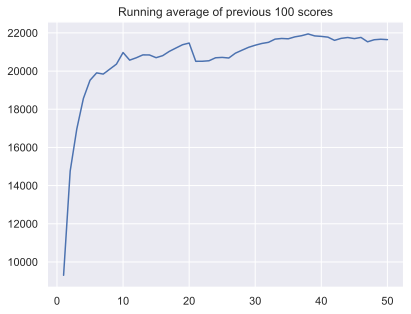

In [82]:
if __name__ == '__main__':
    seed = 42
    np.random.seed(seed)
    T.manual_seed(seed)
    T.cuda.manual_seed(seed)
    T.cuda.manual_seed_all(seed)
    env = BS_EV()
    # kettle, rice cooker, dish washer, washing machine
    N = 20
    batch_size =16
    n_epochs = 4
    alpha = 0.0001
    agent = Agent(n_actions=env.n_actions, batch_size=batch_size, 
                    alpha=alpha, n_epochs=n_epochs, 
                    input_dims=env.n_states)
    n_games = 50

    figure_file = 'figure/learning_curve_PPO.png'

    best_score = float('-inf')
    score_history = []

    learn_iters = 0
    avg_score = 0
    n_steps = 0

    for i in tqdm(range(n_games)):
        observation = env.reset()
        done = False
        score = 0
        while not done:
            #print(env.T)
            action, prob, val = agent.choose_action(observation)
            observation_, reward, done = env.step(action)
            n_steps += 1
            score += reward
            agent.remember(observation, action, prob, val, reward, done)
            if n_steps % N == 0:
                agent.learn()
                learn_iters += 1
            observation = observation_
        score_history.append(score)
        avg_score = np.mean(score_history[-100:])

        if avg_score > best_score:
            best_score = avg_score
            agent.save_models_best()

        print('episode', i, 'score %.1f' % score, 'avg score %.1f' % avg_score,
                'time_steps', n_steps, 'learning_steps', learn_iters)
    agent.save_models_last()
    x = [i+1 for i in range(len(score_history))]
    plot_learning_curve(x, score_history, figure_file)